# Imports

In [1]:
# for managing files
import os
# for storing features
import pickle
import numpy as np
# for providing UI about how much data processed
from tqdm.notebook import tqdm
# for extracting features from images data, and preprocessing data for model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# for text preprocessing, such as converting text to lowercase, filtering out stop words
from tensorflow.keras.preprocessing.text import Tokenizer
# for pading or truncating the sequence so that all sequences have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
# for compiling the model with loss function, optimizer or dataset training
from tensorflow.keras.models import Model
# for converting labels or words into vectors (1 or 0), and model visualization
from tensorflow.keras.utils import to_categorical, plot_model
# for importing model layers
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
dataset_dir = '/kaggle/input/flickr8k'
features_dir = '/kaggle/input/Flickr-features'
work_dir = '/kaggle/working'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Extract Image Features

In [ ]:
# extract features from image
#features = {}
#directory = os.path.join(dataset_dir, 'Images')

#for img_name in tqdm(os.listdir(directory)):
#    # load the image from file
#    img_path = directory + '/' + img_name
#    image = load_img(img_path, target_size=(224, 224))
#    # get image ID
#    image_id = img_name.split('.')[0]
#    # convert image pixels to numpy array
#    image = img_to_array(image)
#    # reshape data for model
#    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#    # preprocess image for vgg
#    image = preprocess_input(image)
#    # extract features
#    feature = model.predict(image, verbose=0)
    
#    # store feature
#    features[image_id] = feature

# Store Image Features

In [ ]:
# store features in pickle
#pickle.dump(features, open(os.path.join(work_dir, 'features.pkl'), 'wb'))

# Load Image Features

In [5]:
# load features from pickle
with open(os.path.join(features_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load Captions

In [6]:
with open(os.path.join(dataset_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

# Map Captions

In [7]:
# map images' captions to each image
imagesCaptions = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    image_name, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    imageID = image_name.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if imageID not in imagesCaptions:
        imagesCaptions[imageID] = []
    # store the caption
    imagesCaptions[imageID].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(imagesCaptions)

8092

# Preprocess Caption Data

In [9]:
def clean(imagesCaptions):
    for image, captions in imagesCaptions.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc..
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = '<s> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <e>'
            captions[i] = caption

In [10]:
# before preprocess of text
imagesCaptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
# preprocess the text
clean(imagesCaptions)

In [12]:
# after preprocess of text
imagesCaptions['1000268201_693b08cb0e']

['<s> child in pink dress is climbing up set of stairs in an entry way <e>',
 '<s> girl going into wooden building <e>',
 '<s> little girl climbing into wooden playhouse <e>',
 '<s> little girl climbing the stairs to her playhouse <e>',
 '<s> little girl in pink dress going into wooden cabin <e>']

In [14]:
all_captions = []
for imageID in imagesCaptions:
    for caption in imagesCaptions[imageID]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40456

In [16]:
all_captions[:10]

['<s> child in pink dress is climbing up set of stairs in an entry way <e>',
 '<s> girl going into wooden building <e>',
 '<s> little girl climbing into wooden playhouse <e>',
 '<s> little girl climbing the stairs to her playhouse <e>',
 '<s> little girl in pink dress going into wooden cabin <e>',
 '<s> black dog and spotted dog are fighting <e>',
 '<s> black dog and tri-colored dog playing with each other on the road <e>',
 '<s> black dog and white dog with brown spots are staring at each other in the street <e>',
 '<s> two dogs of different breeds looking at each other on the road <e>',
 '<s> two dogs on pavement moving toward each other <e>']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8484

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Split Train & Test Sets

In [20]:
imageIDs = list(imagesCaptions.keys())
splitPercentage = int(len(imageIDs) * 0.90)
train = imageIDs[:splitPercentage]
test = imageIDs[splitPercentage:]

In [ ]:
#        '<s> girl going into wooden building <e>'

#        (capt_VectorSeq)                             (newSeq)

#         <s>                                          girl
#         <s> girl                                     going
#         <s> girl going                               into
#         <s> girl going into                          wooden
#         <s> girl going into wooden                   building    
#         <s> girl going into wooden building          <e>

In [22]:
# create a prediction sequence for the training part
def sequenceGenerator(imageIDs, imagesCaptions, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    img_FeatureSeq, capt_VectorSeq, newSeq = list(), list(), list()
    n = 0
    while 1:
        for imageID in imageIDs:
            n += 1
            captions = imagesCaptions[imageID]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    img_FeatureSeq.append(features[imageID][0])
                    capt_VectorSeq.append(in_seq)
                    newSeq.append(out_seq)
                    
            if n == batch_size:
                img_FeatureSeq, capt_VectorSeq, newSeq = np.array(img_FeatureSeq), np.array(capt_VectorSeq), np.array(newSeq)
                yield [img_FeatureSeq, capt_VectorSeq], newSeq
                img_FeatureSeq, capt_VectorSeq, newSeq = list(), list(), list()
                n = 0

# Creating the Caption Generator Model

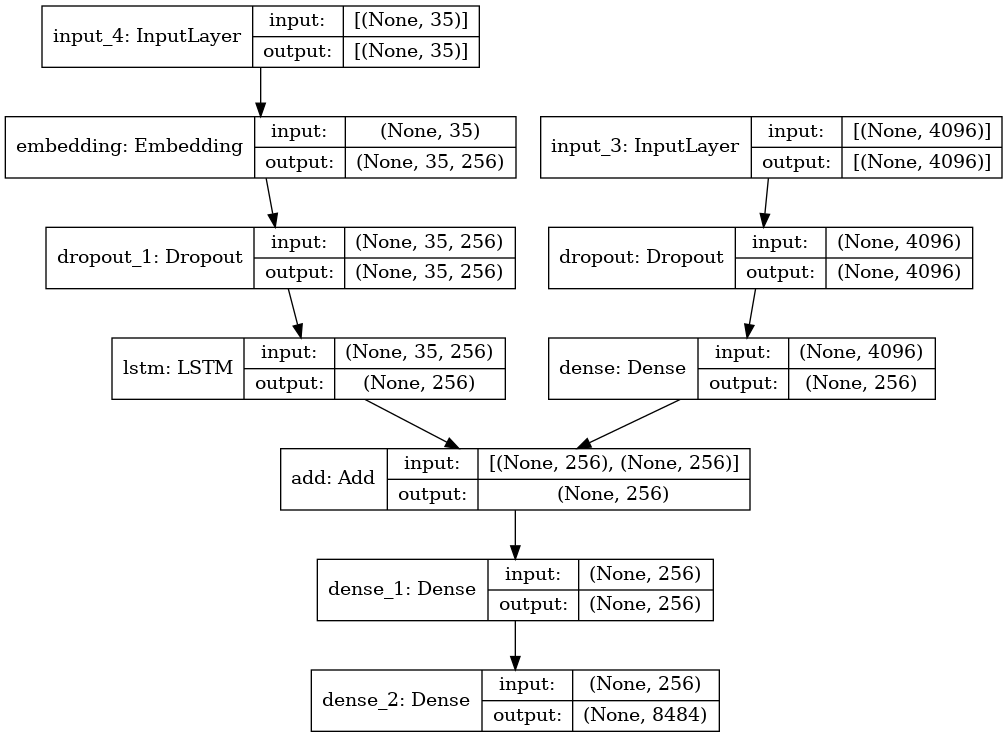

In [23]:
# ENCODING MODEL
imagesInput = Input(shape=(4096,))
imagesDrop = Dropout(0.4)(imagesInput)
imagesOutput = Dense(256, activation='relu')(imagesDrop)

captionsInput = Input(shape=(max_length,))
captionsEmbed = Embedding(vocab_size, 256, mask_zero=True)(captionsInput)
captionsDrop = Dropout(0.4)(captionsEmbed)
captionsOutput = LSTM(256)(captionsDrop)

# DECODING MODEL
mergeModels = add([imagesOutput, captionsOutput])
mergeOutput = Dense(256, activation='relu')(mergeModels)
Output = Dense(vocab_size, activation='softmax')(mergeOutput)

model = Model(inputs=[imagesInput, captionsInput], outputs = Output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot model
plot_model(model, show_shapes=True)